In [1]:
!rm -rf ./tmp

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mmcv
from mmengine.visualization import Visualizer
from pprint import pprint
import pandas as pd
from mmpose.apis import MMPoseInferencer
from modules.utils.visualization import generate_connection_line, joint_colors
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.lifter_2d_3d.model.jointformer.lit_jointformer import LitJointFormer
from modules.lifter_2d_3d.model.semgcn.lit_semgcn import LitSemGCN
from modules.lifter_2d_3d.model.graformer.lit_graformer import LitGraformer
from modules.lifter_2d_3d.utils.normalization import rotate2D_to_x_axis, rotate3D_to_x_axis

## DEFINE MODELS
### Faster RCNN for Human Detection
mmdet_config_path = './modules/human_detector/config/faster_rcnn.py'
mmdet_model_weight = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/'\
        'faster_rcnn_r50_fpn_1x_coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth'

### HR-Net for 2D Pose Estimation
mmpose_config_path = './modules/pose_estimator_2d/config/hrnet.py'
mmpose_model_weight = 'https://download.openmmlab.com/mmpose/v1/'\
        'body_2d_keypoint/topdown_heatmap/coco/'\
            'td-hm_hrnet-w48_udp-8xb32-210e_coco-384x288-70d7ab01_20220913.pth'
mmpose_inferencer = MMPoseInferencer(
    pose2d=mmpose_config_path,
    pose2d_weights=mmpose_model_weight,
    det_model=mmdet_config_path,
    det_weights=mmdet_model_weight,
    det_cat_ids=[0]
)

# 2D-3D Lifter
# pretrained_model_path = './saved_lifter_2d_3d_model/LitSimpleBaselineLinear/drive_and_act/inner_mirror_predicted/transfer_learning/synthetic_cabin_ir/Rear_Mirror_gt/all_actors'
# pretrained_model_path = './saved_lifter_2d_3d_model/LitSimpleBaselineLinear/synthetic_cabin_ir/Rear_Mirror_gt'

# Train only on the drive & act center view
# pretrained_model_path = './saved_model/LitSimpleBaselineLinear/drive_and_act/inner_mirror/all_actors'
# Train only on the synthetic cabin ir 1m center view
# pretrained_model_path = './saved_model/LitSimpleBaselineLinear/synthetic_cabin_ir_1m/Rear_Mirror_gt'
# Pretrained with synthetic cabin ir 1m / finetuned drive and act
# pretrained_model_path = './saved_model/LitSimpleBaselineLinear/drive_and_act/inner_mirror/transfer_learning/synthetic_cabin_ir_1m/Rear_Mirror_gt/all_actors'

# pretrained_model_path = './saved_lifter_2d_3d_model/rq2/LitSimpleBaselineLinear/synthetic_cabin_ir_1m/Dashboard_Front_Front_Left_OMS_01'
# with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
#     checkpoint_path = f.readline()
# print(checkpoint_path)
# lifter_model = LitSimpleBaselineLinear.load_from_checkpoint(checkpoint_path)

# pretrained_model_path = './saved_lifter_2d_3d_model/semgcn/drive_and_act/transfer_learning/synthetic_cabin_ir/all_actors/model_all_actor'
# with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
#     checkpoint_path = f.readline()


# pretrained_model_path = './saved_lifter_2d_3d_model/rq2/LitJointFormer/synthetic_cabin_ir_1m/Dashboard_Front_Front_Left_OMS_01'
# pretrained_model_path = './saved_lifter_2d_3d_model/rq2/LitJointFormer/synthetic_cabin_ir_1m/all_views'
# with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
#     checkpoint_path = f.readline()
# print(checkpoint_path)
# lifter_model = LitJointFormer.load_from_checkpoint(checkpoint_path)
# lifter_model = lifter_model.eval()


pretrained_model_path = './saved_lifter_2d_3d_model/rq2/LitSemGCN/synthetic_cabin_ir_1m/Dashboard_Front_Front_Left_OMS_01'
# pretrained_model_path = './saved_lifter_2d_3d_model/rq2/LitSemGCN/synthetic_cabin_ir_1m/all_views'
with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
    checkpoint_path = f.readline()
print(checkpoint_path)
lifter_model = LitSemGCN.load_from_checkpoint(checkpoint_path)
lifter_model = lifter_model.eval()


## INFERENCE
# video_file = '/root/data/raw/alplab/center.mp4'
# video_file = '/root/data/raw/alplab/right.mp4'
video_file = '/root/data/raw/alplab/drive_and_act_right.mp4'

cap = cv2.VideoCapture(video_file)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
sampling_rate = int(0.5 * np.floor(frame_rate))

print(total_frames)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_udp-8xb32-210e_coco-384x288-70d7ab01_20220913.pth
02/06 20:30:29 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
02/06 20:30:29 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth
02/06 20:30:29 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the curr

idx 0
idx 1
idx 2
idx 3


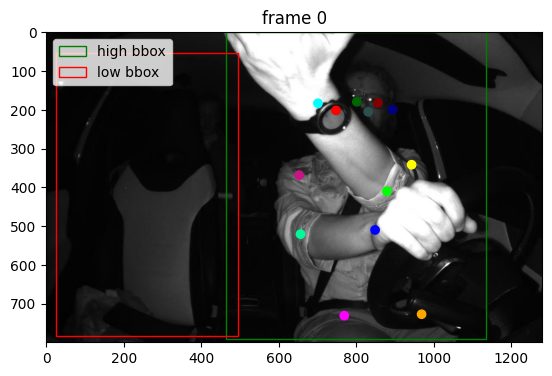

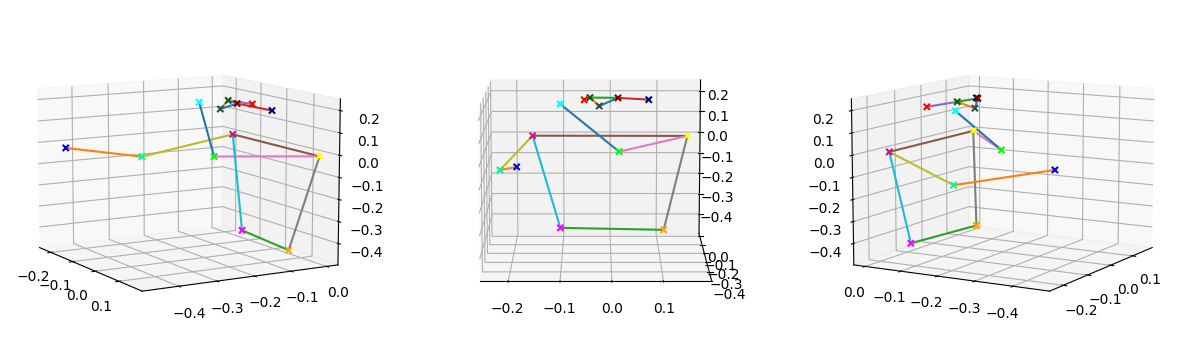

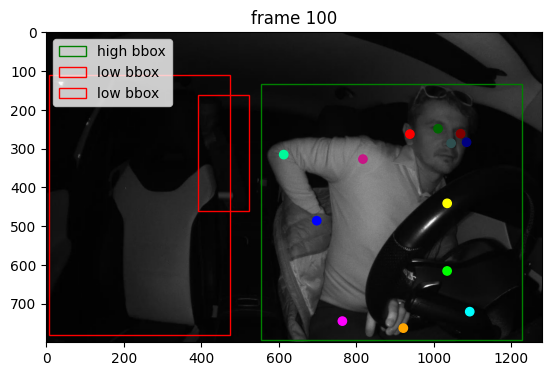

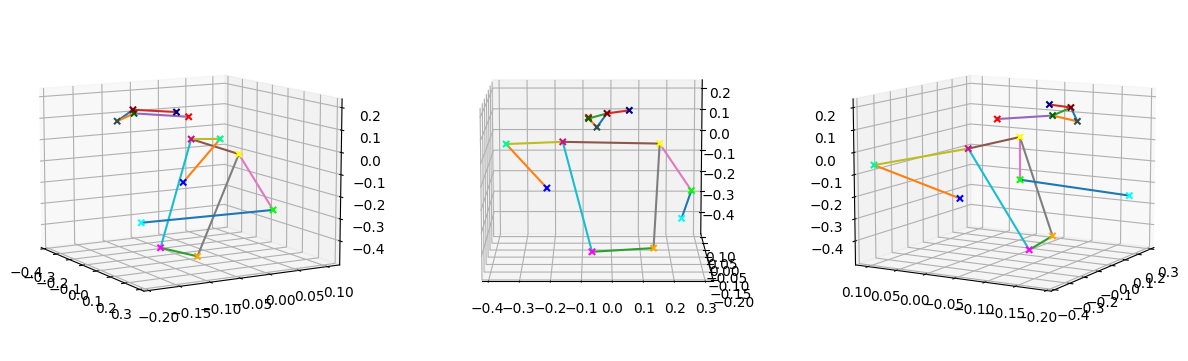

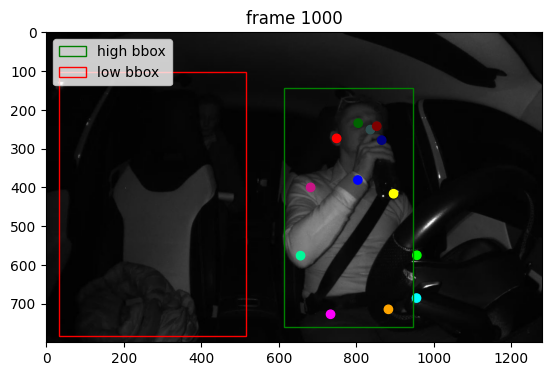

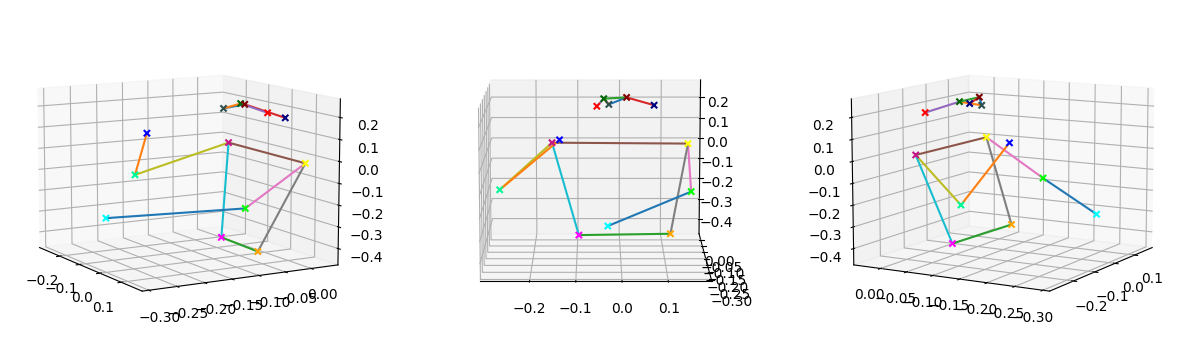

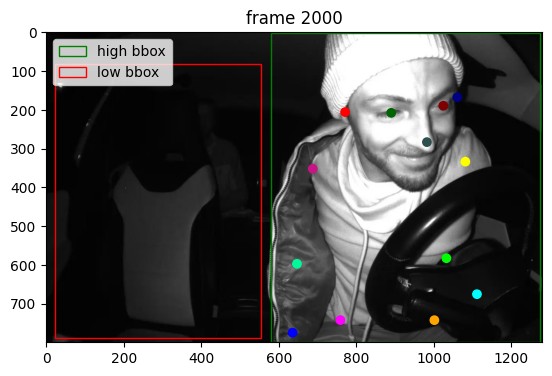

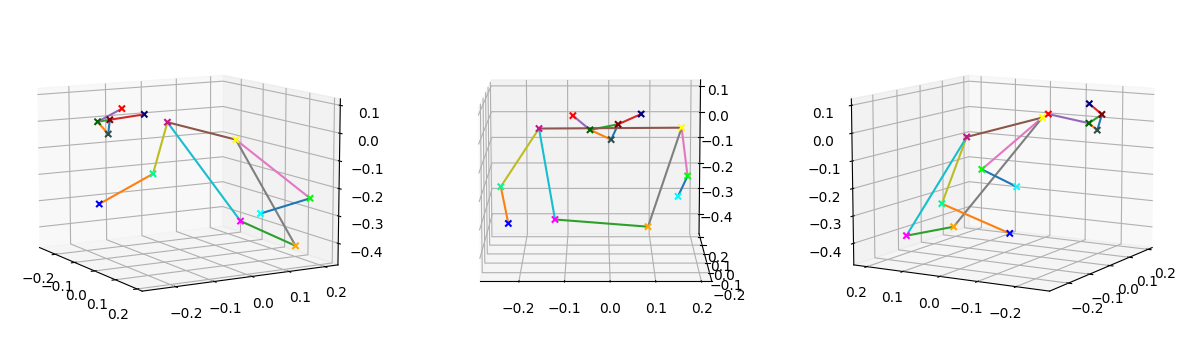

In [3]:
images = []
num_keypoints = 13
frame_numbers = [0, 100, 1000, 2000, 3000, 4000, 5000]
# frame_numbers = [1000]
from scipy import ndimage

# for frame_number in frame_numbers:
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
#     _, image = cap.read()
#     # image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     # image = ndimage.rotate(image, 40)
#     images.append(image)
# images = [cv2.imread('/root/data/processed/drive_and_act/images/train/34770.jpg')]
# images = [cv2.imread('/root/data/processed/drive_and_act/images/train/34770.jpg')]
# images = [cv2.imread('/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/A_Pillar_Codriver/images/test/000000446876.jpg')]
# images = [cv2.imread('/root/data/processed/synthetic_cabin_ir/Rear_Mirror/images/test/000000000006.jpg')]
# images = [cv2.imread('/root/data/processed/synthetic_cabin_ir/Rear_Mirror/images/train/000000006251.jpg')]
image_files = [
    # 'output_2602_Talking-on-phone.jpg',
    # 'output_2900_Seatbelt.jpg',
    # 'output_3717_Adjust-rear-mirror.jpg',
    # 'output_12177_Seatbelt.jpg',
    # 'output_13883_Reach-objects.jpg',
    # 'output_23457_Reach-objects.jpg',
    'output_24310_Adjust-rear-mirror.jpg',
    'output_24680_Put-onoff-jacket.jpg',
    'output_25648_Eating-drinking.jpg',
    'output_450331_Put-onoff-jacket.jpg'
]
    # cv2.imread('/root/data/raw/alplab/alplab_samples/center_frames/output_291_Talking-on-phone.jpg'),   
    # cv2.imread('/root/data/raw/alplab/alplab_samples/center_frames/output_3334_Seatbelt.jpg'),
    # cv2.imread('/root/data/raw/alplab/alplab_samples/center_frames/output_4355_Texting-on-phone.jpg'),
    # cv2.imread('/root/data/raw/alplab/alplab_samples/center_frames/output_32326_Switch-gear.jpg'),
images = [cv2.imread(f'/root/data/raw/alplab/alplab_samples/center_frames/{file}') for file in image_files]
## Model Inference
mmpose_results = mmpose_inferencer(images)
for idx, mmpose_result in enumerate(mmpose_results):
    print('idx', idx)
    image_results = mmpose_result['predictions'][0]
    fig, ax = plt.subplots()
    ax.imshow(images[idx])
    ax.set_title(f'frame {frame_numbers[idx]}')
    # find the best box
    best_box_idx = np.argmax([box['bbox_score'] for box in image_results])
    for idx, detected in enumerate(image_results):
        ## bounding box in top-left / bottom-right format
        # pprint(detected)
        bbox = detected['bbox']
        x = bbox[0][0]
        y = bbox[0][1]
        w = bbox[0][2] - bbox[0][0]
        h = bbox[0][3] - bbox[0][1]
        # print(x, y, w, h)
        if idx != best_box_idx:
            # draw lower match bbox as red
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label='low bbox')
        else:
            # draw highest match bbox as green
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none', label='high bbox')
            # plot 2D keypoints
            pose_2d = np.array(detected['keypoints'])
            ax.scatter(pose_2d[:num_keypoints, 0], pose_2d[:num_keypoints, 1], c=joint_colors[:num_keypoints])
            image_height, image_width, _ = images[idx].shape

            # New Scaling ###################################################
            # scale by the max-min position of 2D poses
            x_max, y_max = np.max(pose_2d[:, :2], axis=0)
            x_min, y_min = np.min(pose_2d[:, :2], axis=0)
            # max_length = np.max([x_max - x_min, y_max - y_min])
            w = x_max - x_min
            h = y_max - y_min
            # w = max_length
            # h = max_length
            bbox = [x_min, y_min, x_max, y_max]
            
            # center
            # use neck as the root. Neck is defined as the center of left/right shoulder
            root_2d = (pose_2d[5, :2] + pose_2d[6, :2]) / 2
            pose_2d[:, :2] = pose_2d[:, :2] - root_2d

            # root_3d = (keypoints3D[5, :] + keypoints3D[6, :]) / 2
            # keypoints3D = keypoints3D - root_3d
            pose_2d[:, :2], rotation_matrix = rotate2D_to_x_axis(pose_2d[5:7, :2], pose_2d[:, :2])
            pose_2d[:, 0] = pose_2d[:, 0] / w
            pose_2d[:, 1] = pose_2d[:, 1] / h
            # pose_3d = rotate3D_to_x_axis(pose_3d[5:7], pose_3d)
            #################################################################
            # pose_3d = lifter_model(torch.flatten(torch.tensor(pose_2d[:num_keypoints])).unsqueeze(0).float().to('cuda'))
            pose_3d = lifter_model(torch.tensor(pose_2d[:num_keypoints]).unsqueeze(0).float().to('cuda'))
            pose_3d_np = pose_3d[0].cpu().reshape([-1, 3]).detach().numpy()
            connections = generate_connection_line(pose_3d_np)
            x = pose_3d_np[:, 0]
            y = pose_3d_np[:, 1]
            z = pose_3d_np[:, 2]
            fig_3d = plt.figure(figsize=(15, 20))
            ax_3d_1 = fig_3d.add_subplot(1, 3, 1, projection='3d')
            predict_plot = ax_3d_1.scatter3D(x, z, -y, c=joint_colors[:num_keypoints], marker='x', depthshade=False, label='Predict')

            for i in range(len(connections) // 2):
                ax_3d_1.plot3D(
                    [connections[2*i]['x'], connections[2*i + 1]['x']],
                    [connections[2*i]['z'], connections[2*i + 1]['z']],
                    [-connections[2*i]['y'], -connections[2*i + 1]['y']],
                )
            ax_3d_1.view_init(elev=10., azim=-30, roll=0)

            ax_3d_2 = fig_3d.add_subplot(1, 3, 2, projection='3d')
            predict_plot = ax_3d_2.scatter3D(x, z, -y, c=joint_colors[:num_keypoints], marker='x', depthshade=False, label='Predict')

            for i in range(len(connections) // 2):
                ax_3d_2.plot3D(
                    [connections[2*i]['x'], connections[2*i + 1]['x']],
                    [connections[2*i]['z'], connections[2*i + 1]['z']],
                    [-connections[2*i]['y'], -connections[2*i + 1]['y']],
                )
            ax_3d_2.view_init(elev=10., azim=-90, roll=0)


            ax_3d_3 = fig_3d.add_subplot(1, 3, 3, projection='3d')
            predict_plot = ax_3d_3.scatter3D(x, z, -y, c=joint_colors[:num_keypoints], marker='x', depthshade=False, label='Predict')

            for i in range(len(connections) // 2):
                ax_3d_3.plot3D(
                    [connections[2*i]['x'], connections[2*i + 1]['x']],
                    [connections[2*i]['z'], connections[2*i + 1]['z']],
                    [-connections[2*i]['y'], -connections[2*i + 1]['y']],
                )
            ax_3d_3.view_init(elev=10., azim=-150, roll=0)

        ax.add_patch(rect)
    ax.legend(loc='upper left')